# Közlekedési hálózatok vizsgálata
## Wikispeedia

A Wikispeedia böngészős játékban a játékos kap (vagy választ magának) két wikipédia cikket, amiknek a témája látszólag nagyon eltérő. A játék célja, hogy a felhasználó az egyik cikkből kiindulva, az oldalon található hivatkozások segítségével eljusson a másik kapott cikk oldalára.

In [1]:
import csv
from urllib.parse import unquote
import matplotlib.pyplot as plt
import networkx as nx
#import nbimporter
#from functions import draw_normalized

### Útvonalak meghatározása kezdő- és végpont alapján

In [2]:
# remove comment rows from file
def decomment(csvfile):
    for row in csvfile:
        raw = row.split('#')[0].strip()
        if raw: yield raw

# read successful paths
def read_path(start = None, end = None):
  check = True if (type(start) == str and type(end) == str) else False
  found = False
  edges = {}
  
  with open("./wikispeedia_paths-and-graph/paths_finished.tsv") as paths:
      rd = csv.reader(decomment(paths), delimiter="\t", quotechar='"')
      for row in rd:

        # decode utf-8 and split path to list
        path = unquote(row[3]).split(sep=";")

        if (check):
           if (start != path[0] or end != path[len(path)-1]):
              if (found):
                 return edges
              else:
                continue
           else:
              found = True

        # delete back clicks from path (represented by "<")
        j = 0
        while (j < len(path)):
            if (path[j] == "<"):
              del path[j]
              del path[j-1]
              j -= 2
            j += 1

        # make graph edges from paths (the weight is determined by the frequency of usage of an article pair)
        for i in range(len(path)-1):
          key_tuple = (path[i], path[i+1])
          if key_tuple in edges.keys():
            w = edges[key_tuple] + 1
          else:
            w = 1
          edges[key_tuple] = w
  return edges

#### Gráfban körök megszűntetése

In [3]:
def no_cycle(graph, cycles = {}):
  curr_cycle = []
  w = 0

  try:
    curr_cycle = nx.find_cycle(graph)
  except:
    return cycles
  else:
    key_tuple = (curr_cycle[len(curr_cycle)-1][0], curr_cycle[len(curr_cycle)-1][1])
    w = graph.get_edge_data(key_tuple[0], key_tuple[1])
    cycles[key_tuple] = w
    graph.remove_edge(key_tuple[0], key_tuple[1])
    no_cycle(graph, cycles)
  finally:
    return cycles

### Leggyakoribb kezdőpont-célpont párok megtalálása

In [4]:
from collections import Counter

pairs = {}

with open("./wikispeedia_paths-and-graph/paths_finished.tsv") as paths:
  rd = csv.reader(decomment(paths), delimiter="\t", quotechar='"')
  for row in rd:
    path = unquote(row[3]).split(sep=";")

    key_tuple = (path[0], path[len(path)-1])
    if key_tuple in pairs.keys():
      count = pairs[key_tuple] + 1
    else:
      count = 1
    pairs[key_tuple] = count

dict(Counter(pairs).most_common(10))

{('Asteroid', 'Viking'): 1043,
 ('Brain', 'Telephone'): 1040,
 ('Theatre', 'Zebra'): 905,
 ('Pyramid', 'Bean'): 642,
 ('Batman', 'Wood'): 148,
 ('Bird', 'Great_white_shark'): 138,
 ('Batman', 'The_Holocaust'): 119,
 ('Bird', 'Adolf_Hitler'): 107,
 ('Beer', 'Sun'): 99,
 ('Batman', 'Banana'): 69}

<hr>

### Példák

In [5]:
uranus_edges = read_path("Uranus", "FIFA")
wiki_uranus = nx.DiGraph()
for k, v in uranus_edges.items():
    k = (k[0].replace('_', '\n'), k[1].replace('_', '\n'))
    wiki_uranus.add_edge(k[0], k[1], weight=v)

uranus_cycles = no_cycle(wiki_uranus)

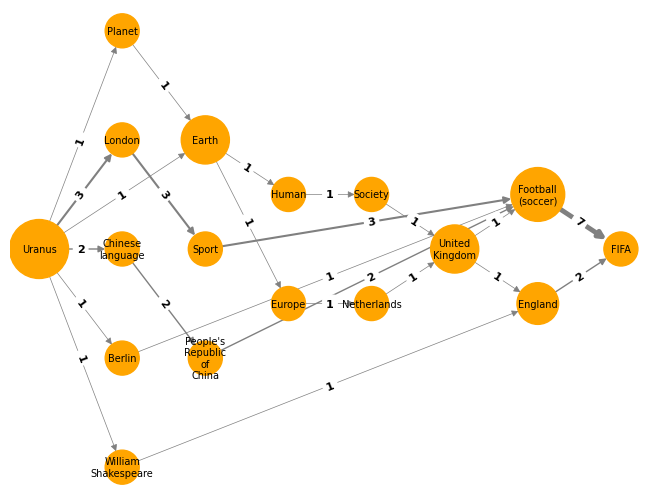

<Figure size 880x640 with 0 Axes>

In [7]:
for layer, nodes in enumerate(nx.topological_generations(wiki_uranus)):
    for node in nodes:
        wiki_uranus.nodes[node]["layer"] = layer

pos = nx.multipartite_layout(wiki_uranus, subset_key="layer")

fig, ax = plt.subplots()

if (len(uranus_cycles) > 0):
  for k, v in uranus_cycles.items():
    wiki_uranus.add_edge(k[0], k[1], weight=v.get('weight'))

weights = [wiki_uranus[u][v]['weight']/2 for u,v in wiki_uranus.edges()]
d = dict(wiki_uranus.degree)

#color_map = []
#for i in range(len(wiki_uranus.nodes())): 
#  if i == 0 or i == len(wiki_uranus.nodes())-1:
#    color_map.append('blue')
#  else:
#     color_map.append('orange')

nx.draw_networkx(wiki_uranus, pos=pos, width=weights, node_size=[d[k]*300 for k in d], node_color='orange', font_size=7, edge_color="gray")

edge_labels = nx.get_edge_attributes(wiki_uranus, "weight")
nx.draw_networkx_edge_labels(wiki_uranus, pos, edge_labels, font_size=8, font_weight="bold")

ax.margins(0)
plt.axis("off")
fig.tight_layout(pad=0)
plt.figure(num=None, figsize=(22, 16), dpi=40)
plt.show()

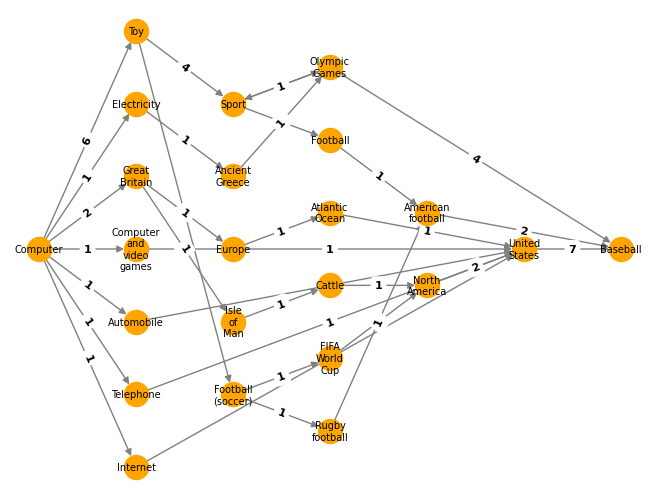

<Figure size 880x640 with 0 Axes>

In [11]:
#pelda_edges = read_path('Batman', 'Albert_Einstein')
#('Batman', 'Albert_Einstein'): 23

#pelda_edges = read_path('Bird_migration', 'Hubble_Space_Telescope')
# ('Bird_migration', 'Hubble_Space_Telescope'): 18}

pelda_edges = read_path('Computer', 'Baseball')
#('Computer', 'Baseball'): 13

wiki_pelda = nx.DiGraph()
for k, v in pelda_edges.items():
    k = (k[0].replace('_', '\n'), k[1].replace('_', '\n'))
    wiki_pelda.add_edge(k[0], k[1], weight=v)

pelda_cycles = no_cycle(wiki_pelda)

for layer, nodes in enumerate(nx.topological_generations(wiki_pelda)):
    for node in nodes:
        wiki_pelda.nodes[node]["layer"] = layer

pos = nx.multipartite_layout(wiki_pelda, subset_key="layer")

fig, ax = plt.subplots()

if (len(pelda_cycles) > 0):
  for k, v in pelda_cycles.items():
    wiki_pelda.add_edge(k[0], k[1], weight=v.get('weight'))

nx.draw_networkx(wiki_pelda, pos=pos, width=1, node_color="orange", font_size=7, edge_color="gray")

edge_labels = nx.get_edge_attributes(wiki_pelda, "weight")
nx.draw_networkx_edge_labels(wiki_pelda, pos, edge_labels, font_size=8, font_weight="bold")

ax.margins(0)
plt.axis("off")
fig.tight_layout(pad=0)
plt.figure(num=None, figsize=(22, 16), dpi=40)
plt.show()